<a href="https://colab.research.google.com/github/anoopsanka/retinal_oct/blob/main/notebooks/03c-OCT_PretrainedSimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cp drive/MyDrive/OCT_Project/ZhangLabData.zip .
!unzip ZhangLabData.zip

Streaming output truncated to the last 5000 lines.
  inflating: CellData/OCT/train/DME/DME-778975-125.jpeg  
  inflating: CellData/OCT/train/DME/DME-258763-26.jpeg  
  inflating: CellData/OCT/train/DME/DME-8457431-23.jpeg  
  inflating: CellData/OCT/train/DME/DME-3304080-55.jpeg  
  inflating: CellData/OCT/train/DME/DME-5006393-70.jpeg  
  inflating: CellData/OCT/train/DME/DME-5091309-15.jpeg  
  inflating: CellData/OCT/train/DME/DME-3064922-181.jpeg  
  inflating: CellData/OCT/train/DME/DME-8525575-184.jpeg  
  inflating: CellData/OCT/train/DME/DME-5143281-26.jpeg  
  inflating: CellData/OCT/train/DME/DME-6737988-35.jpeg  
  inflating: CellData/OCT/train/DME/DME-3064922-202.jpeg  
  inflating: CellData/OCT/train/DME/DME-3531101-20.jpeg  
  inflating: CellData/OCT/train/DME/DME-3157783-58.jpeg  
  inflating: CellData/OCT/train/DME/DME-258763-41.jpeg  
  inflating: CellData/OCT/train/DME/DME-30521-85.jpeg  
  inflating: CellData/OCT/train/DME/DME-5489583-15.jpeg  
  inflating: CellData/

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
seed = 42
val_split   = 0.02
train_split = 1 - val_split
batch_size = 32
IMG_SIZE=224

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    'CellData/OCT/train',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    validation_split=val_split,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    )
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'CellData/OCT/train',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    validation_split=val_split,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    )

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    'CellData/OCT/test',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    interpolation="bilinear",
    follow_links=False,
    )

Found 108309 files belonging to 4 classes.
Using 2166 files for validation.
Found 108309 files belonging to 4 classes.
Using 106143 files for training.
Found 1000 files belonging to 4 classes.


# Feature Extraction with Pretrained SimCLR
- Ultimately we want to train a SimCLR model with the wealth of OCT images
- as a zeroth step, we ask how well are SimCLR pretrained on ImageNet works on the unseen OCT images domain.
- we use SimCLR as a feature extractor and try to see how well a simple linear classification head (multi-class logistic regression) works in terms of distinguiishing between classes


In [ ]:
#@title Load module and construct the computation graph
import tensorflow_hub as hub
import tensorflow as tf
# Load the base network and set it to non-trainable (for speedup fine-tuning)
hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'

In [ ]:
input_layer  = tf.keras.layers.Input((224,224,3))
simclr_layer = hub.KerasLayer(hub_path, trainable=False,)
classification_head = tf.keras.layers.Dense(4, activation='softmax')


model = tf.keras.Sequential([input_layer, 
                             simclr_layer,
                             classification_head])

In [ ]:
metrics = ['accuracy']
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', ),
             tf.keras.callbacks.ModelCheckpoint(filepath='resnet_model.{epoch:02d}-{val_loss:.2f}.h5'),]
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=metrics)

In [ ]:
import os

# simple version for working with CWD
nCNV = len([name for name in os.listdir('CellData/OCT/train/CNV')])
nDME = len([name for name in os.listdir('CellData/OCT/train/DME')])
nDRUSEN = len([name for name in os.listdir('CellData/OCT/train/DRUSEN')])
nNORMAL = len([name for name in os.listdir('CellData/OCT/train/NORMAL')])

ncount = np.array([nCNV, nDME, nDRUSEN, nNORMAL])
ntotal = sum(ncount)

weights = ntotal/ncount/ len(ncount)
weights /= weights.min()
class_weight = {i: w for i, w in enumerate(weights)}

# Retrieve the Representation
- we run our examples through the SimCLR to retrieve the embedding as seen by the nerual network


In [ ]:
def get_representation(dataset, max_batch=500):
  out_rep, out_label = [], []
  count = 0
  for img, lb in dataset:
    out_rep.append(simclr_layer(img).numpy())
    out_label.append(lb.numpy())
    if count % 100 == 0: print(f'count = {count}')
    if count > max_batch: break
    count += 1
  out_label = np.hstack(out_label)
  out_rep   = np.vstack(out_rep)
  return out_rep, out_label

In [ ]:
# train_rep, train_lb = get_representation(ds_train)
test_rep,  test_lb = get_representation(ds_test)

count = 0


In [ ]:
train_rep, train_lb = get_representation(ds_train)

count = 0
count = 100
count = 200
count = 300
count = 400
count = 500


In [ ]:
train_rep = train_rep / np.sqrt(np.square(train_rep).mean(axis=-1, keepdims=True))
test_rep  = test_rep  / np.sqrt(np.square(test_rep).mean(axis=-1, keepdims=True))

In [ ]:
train_rep.shape

(16064, 2048)

In [ ]:
import os

# simple version for working with CWD
nCNV = len([name for name in os.listdir('CellData/OCT/train/CNV')])
nDME = len([name for name in os.listdir('CellData/OCT/train/DME')])
nDRUSEN = len([name for name in os.listdir('CellData/OCT/train/DRUSEN')])
nNORMAL = len([name for name in os.listdir('CellData/OCT/train/NORMAL')])

ncount = np.array([nCNV, nDME, nDRUSEN, nNORMAL])
ntotal = sum(ncount)

weights = ntotal/ncount/ len(ncount)
weights /= weights.min()
class_weight = {i: w for i, w in enumerate(weights)}

# Fitting a Linear Regression Model
- attach a dense layer with 4 outputs with softmax activation
- minimize the cross-entropy taking into the account of the inherent imbalance between the 4 classes

In [ ]:
learning_rate = 1.0e-3


linearRegression = tf.keras.Sequential([tf.keras.layers.Input(2048),
                                       tf.keras.layers.Dense(4, activation='softmax')])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
linearRegression.compile(loss='sparse_categorical_crossentropy', 
                         metrics='accuracy', 
                         optimizer=optimizer)

In [ ]:
history = linearRegression.fit(train_rep, 
                              train_lb, 
                              batch_size=32, 
                              epochs=100,
                              class_weight=class_weight,
                              validation_data=(test_rep, test_lb),)

Epoch 1/100
502/502 [==============================] - 2s 3ms/step - loss: 2.6712 - accuracy: 0.3238 - val_loss: 1.2323 - val_accuracy: 0.4440
Epoch 2/100
502/502 [==============================] - 1s 2ms/step - loss: 2.4237 - accuracy: 0.4581 - val_loss: 1.2012 - val_accuracy: 0.5060
Epoch 3/100
502/502 [==============================] - 1s 3ms/step - loss: 2.2767 - accuracy: 0.5036 - val_loss: 1.0879 - val_accuracy: 0.5720
Epoch 4/100
502/502 [==============================] - 1s 2ms/step - loss: 2.2520 - accuracy: 0.5171 - val_loss: 1.0696 - val_accuracy: 0.5390
Epoch 5/100
502/502 [==============================] - 1s 3ms/step - loss: 2.1339 - accuracy: 0.5474 - val_loss: 1.0467 - val_accuracy: 0.5520
Epoch 6/100
502/502 [==============================] - 1s 2ms/step - loss: 2.0790 - accuracy: 0.5624 - val_loss: 1.0043 - val_accuracy: 0.6080
Epoch 7/100
502/502 [==============================] - 1s 3ms/step - loss: 2.0589 - accuracy: 0.5631 - val_loss: 1.0670 - val_accuracy: 0.5460

In [ ]:
history = linearRegression.fit(train_rep, 
                               train_lb, 
                               batch_size=32, 
                               epochs=400,
                               class_weight=class_weight,
                               validation_data=(test_rep, test_lb),
                               initial_epoch=200)

Epoch 201/400
502/502 [==============================] - 1s 2ms/step - loss: 1.5641 - accuracy: 0.6825 - val_loss: 0.9435 - val_accuracy: 0.6400
Epoch 202/400
502/502 [==============================] - 1s 2ms/step - loss: 1.5574 - accuracy: 0.6835 - val_loss: 0.9800 - val_accuracy: 0.6010
Epoch 203/400
502/502 [==============================] - 1s 2ms/step - loss: 1.5574 - accuracy: 0.6856 - val_loss: 0.9580 - val_accuracy: 0.5890
Epoch 204/400
502/502 [==============================] - 1s 2ms/step - loss: 1.5554 - accuracy: 0.6813 - val_loss: 0.9345 - val_accuracy: 0.6230
Epoch 205/400
502/502 [==============================] - 1s 2ms/step - loss: 1.5583 - accuracy: 0.6830 - val_loss: 0.9396 - val_accuracy: 0.6260
Epoch 206/400
502/502 [==============================] - 1s 2ms/step - loss: 1.5549 - accuracy: 0.6845 - val_loss: 0.8698 - val_accuracy: 0.6410
Epoch 207/400
502/502 [==============================] - 1s 2ms/step - loss: 1.5513 - accuracy: 0.6836 - val_loss: 1.0484 - val_ac

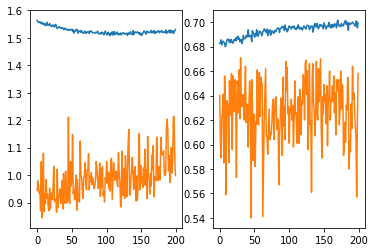

In [ ]:
f = plt.figure()
ax1 = f.add_subplot(1,2,1)
ax1.plot(linearRegression.history.history['loss'])
ax1.plot(linearRegression.history.history['val_loss'])

ax2 = f.add_subplot(1,2,2)
ax2.plot(linearRegression.history.history['accuracy'])
ax2.plot(linearRegression.history.history['val_accuracy'])

In [ ]:
ypred_train = linearRegression(train_rep).numpy().argmax(axis=-1)
ypred_test  = linearRegression(test_rep).numpy().argmax(axis=-1)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(train_lb, ypred_train))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81      5548
           1       0.48      0.68      0.56      1743
           2       0.23      0.70      0.34      1318
           3       0.91      0.58      0.71      7455

    accuracy                           0.66     16064
   macro avg       0.62      0.68      0.60     16064
weighted avg       0.79      0.66      0.70     16064



In [ ]:
print(classification_report(test_lb, ypred_test))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       250
           1       0.66      0.86      0.75       250
           2       0.52      0.42      0.47       250
           3       0.75      0.45      0.56       250

    accuracy                           0.64      1000
   macro avg       0.64      0.64      0.63      1000
weighted avg       0.64      0.64      0.63      1000



# NOT BAD!!
- with only a linear regression, we achieve an overall accuracy of 65%, as opposed to a completely random guess with gives 25 %!
- a good baseline on a SimCLR trained on the actual image distribution! 

In [ ]:
# http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias